In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8, 4]

In [2]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


# Convolutional Neural Networks (CNN)

In [3]:
# codes from https://www.tensorflow.org/tutorials/layers

def cnn_model_fn(features, labels, mode):
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
      
    conv1 = tf.layers.conv2d(inputs=input_layer,
                             filters=32,
                             kernel_size=[5, 5],
                             padding="same",
                             activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(inputs=pool1,
                             filters=64,
                             kernel_size=[5, 5],
                             padding="same",
                             activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {"classes": tf.argmax(input=logits, axis=1),
                   "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [4]:
mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'mnist_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B32195CDD8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [5]:
logging_hook = tf.train.LoggingTensorHook(tensors={}, at_end=True)

train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": train_data},
                                                    y=train_labels,
                                                    batch_size=100,
                                                    num_epochs=None,
                                                    shuffle=True)
mnist_classifier.train(input_fn=train_input_fn,
                       steps=2000,
                       hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into mnist_convnet_model\model.ckpt.
INFO:tensorflow:loss = 2.294982, step = 1
INFO:tensorflow:global_step/sec: 6.54853
INFO:tensorflow:loss = 0.31479234, step = 101 (15.271 sec)
INFO:tensorflow:global_step/sec: 6.5805
INFO:tensorflow:loss = 0.07736204, step = 201 (15.196 sec)
INFO:tensorflow:global_step/sec: 6.57486
INFO:tensorflow:loss = 0.2559571, step = 301 (15.210 sec)
INFO:tensorflow:global_step/sec: 6.5905
INFO:tensorflow:loss = 0.03341827, step = 401 (15.172 sec)
INFO:tensorflow:global_step/sec: 6.55541
INFO:tensorflow:loss = 0.10857181, step = 501 (15.255 sec)
INFO:tensorflow:global_step/sec: 6.41831
INFO:tensorflow:loss = 0.16234039, step = 601 (15.580 sec)
INFO:tensorflow:global_step/sec: 6.49141
INFO:tensorflow:loss = 0.0043805963, step = 701 (15.405 sec)
INFO:tensorflow:global_step/sec: 6.49014
INFO:tensorflow:loss = 0.03598695, step = 801 (15.412 sec)
INFO:tensorflow:global_step/sec: 6.57

In [6]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": eval_data},
                                                   y=eval_labels,
                                                   num_epochs=1,
                                                   shuffle=False)
mnist_classifier.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Starting evaluation at 2018-02-20-04:57:04
INFO:tensorflow:Restoring parameters from mnist_convnet_model\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2018-02-20-04:57:09
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.992, global_step = 2000, loss = 0.0240143


{'accuracy': 0.992, 'global_step': 2000, 'loss': 0.0240143}

INFO:tensorflow:Restoring parameters from mnist_convnet_model\model.ckpt-2000


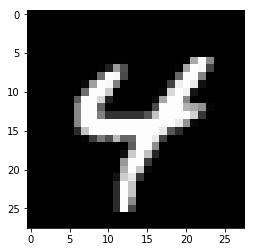

Model prediction: {'classes': 4, 'probabilities': array([9.19842121e-15, 1.45196355e-11, 6.36655162e-16, 2.08180200e-15,
       9.99999523e-01, 2.37653972e-12, 1.80850628e-13, 2.10186209e-12,
       2.05874029e-09, 5.22458549e-07], dtype=float32)}


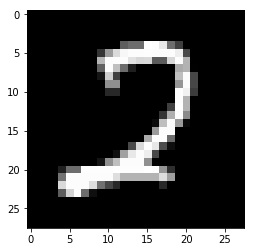

Model prediction: {'classes': 2, 'probabilities': array([1.6108204e-05, 3.8240058e-04, 9.9935323e-01, 1.1322340e-04,
       7.1983169e-07, 4.6093660e-07, 4.5918069e-09, 1.2341717e-04,
       6.0624207e-06, 4.4323933e-06], dtype=float32)}


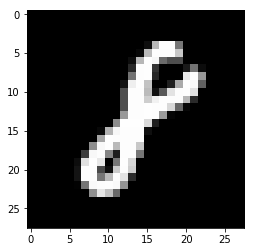

Model prediction: {'classes': 8, 'probabilities': array([2.9821376e-08, 9.8930821e-07, 3.5042664e-08, 2.1246747e-06,
       1.5836677e-07, 7.7379582e-07, 8.3674138e-07, 6.2174514e-09,
       9.9999499e-01, 1.3969508e-08], dtype=float32)}


In [13]:
test_images = eval_data[np.random.choice(mnist.test.num_examples, 3)]
input_fn = tf.estimator.inputs.numpy_input_fn(x={'x': test_images}, shuffle=False)
preds = list(mnist_classifier.predict(input_fn))

for i in range(3):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])

# 끗